In [1]:
import sqlite3
import re

import pandas
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (20, 10)})
sns.set(font_scale=1.5)
sns.set_style("ticks")

In [2]:
connection = sqlite3.connect("b2b_google_analytics.db")

---

In [3]:
cursor = connection.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type = 'table' AND name NOT LIKE 'sqlite_%';")
table_names = [t[0] for t in cursor]
cursor.close()

In [4]:
def plot_duration_vs_users(table_name):
    def get_duration(name):
        return pandas.read_sql("SELECT event_time, session_duration FROM {} WHERE session_duration != 0".format(name),
                               connection, parse_dates={"event_time" : "%H:%M"})
    def get_users(name):
        return pandas.read_sql("SELECT distinct event_time, user_id from {} WHERE session_duration != 0".format(name),
                               connection, parse_dates={"event_time" : "%H:%M"})
    
    all_duration_df = pandas.DataFrame()
    all_users_df = pandas.DataFrame()
    
    if table_name == "Overall":
        for name in table_names:
            all_duration_df = all_duration_df.append(get_duration(name), ignore_index=True)
            all_users_df = all_users_df.append(get_users(name), ignore_index=True)
    else:
        all_duration_df = get_duration(table_name)
        all_users_df = get_users(table_name)
        
    all_duration_df["event_hour"] = all_duration_df["event_time"].dt.hour
    all_users_df["event_hour"] = all_users_df["event_time"].dt.hour

    all_duration_df = all_duration_df.groupby(["event_hour"]).agg({"session_duration" : "mean"}).reset_index()
    ax = sns.lineplot(data=all_duration_df, x="event_hour", y="session_duration", linewidth=3)

    dual = ax.twinx()
    dual._get_lines.prop_cycler = ax._get_lines.prop_cycler

    all_users_df = all_users_df.groupby(["event_hour"]).agg({"user_id" : "count"})
    sns.lineplot(data=all_users_df, x="event_hour", y="user_id", ax=dual, linewidth=3)

    dual.set(ylabel="Number of Unique Users")
    ax.set(xlabel="Event Hour (24)", ylabel="Average Session Duration")
    ax.legend(["Average Session Duration"], loc=2)
    dual.legend(["Number of Unique Users"], bbox_to_anchor=(0.23, 0.94))
    plt.show()

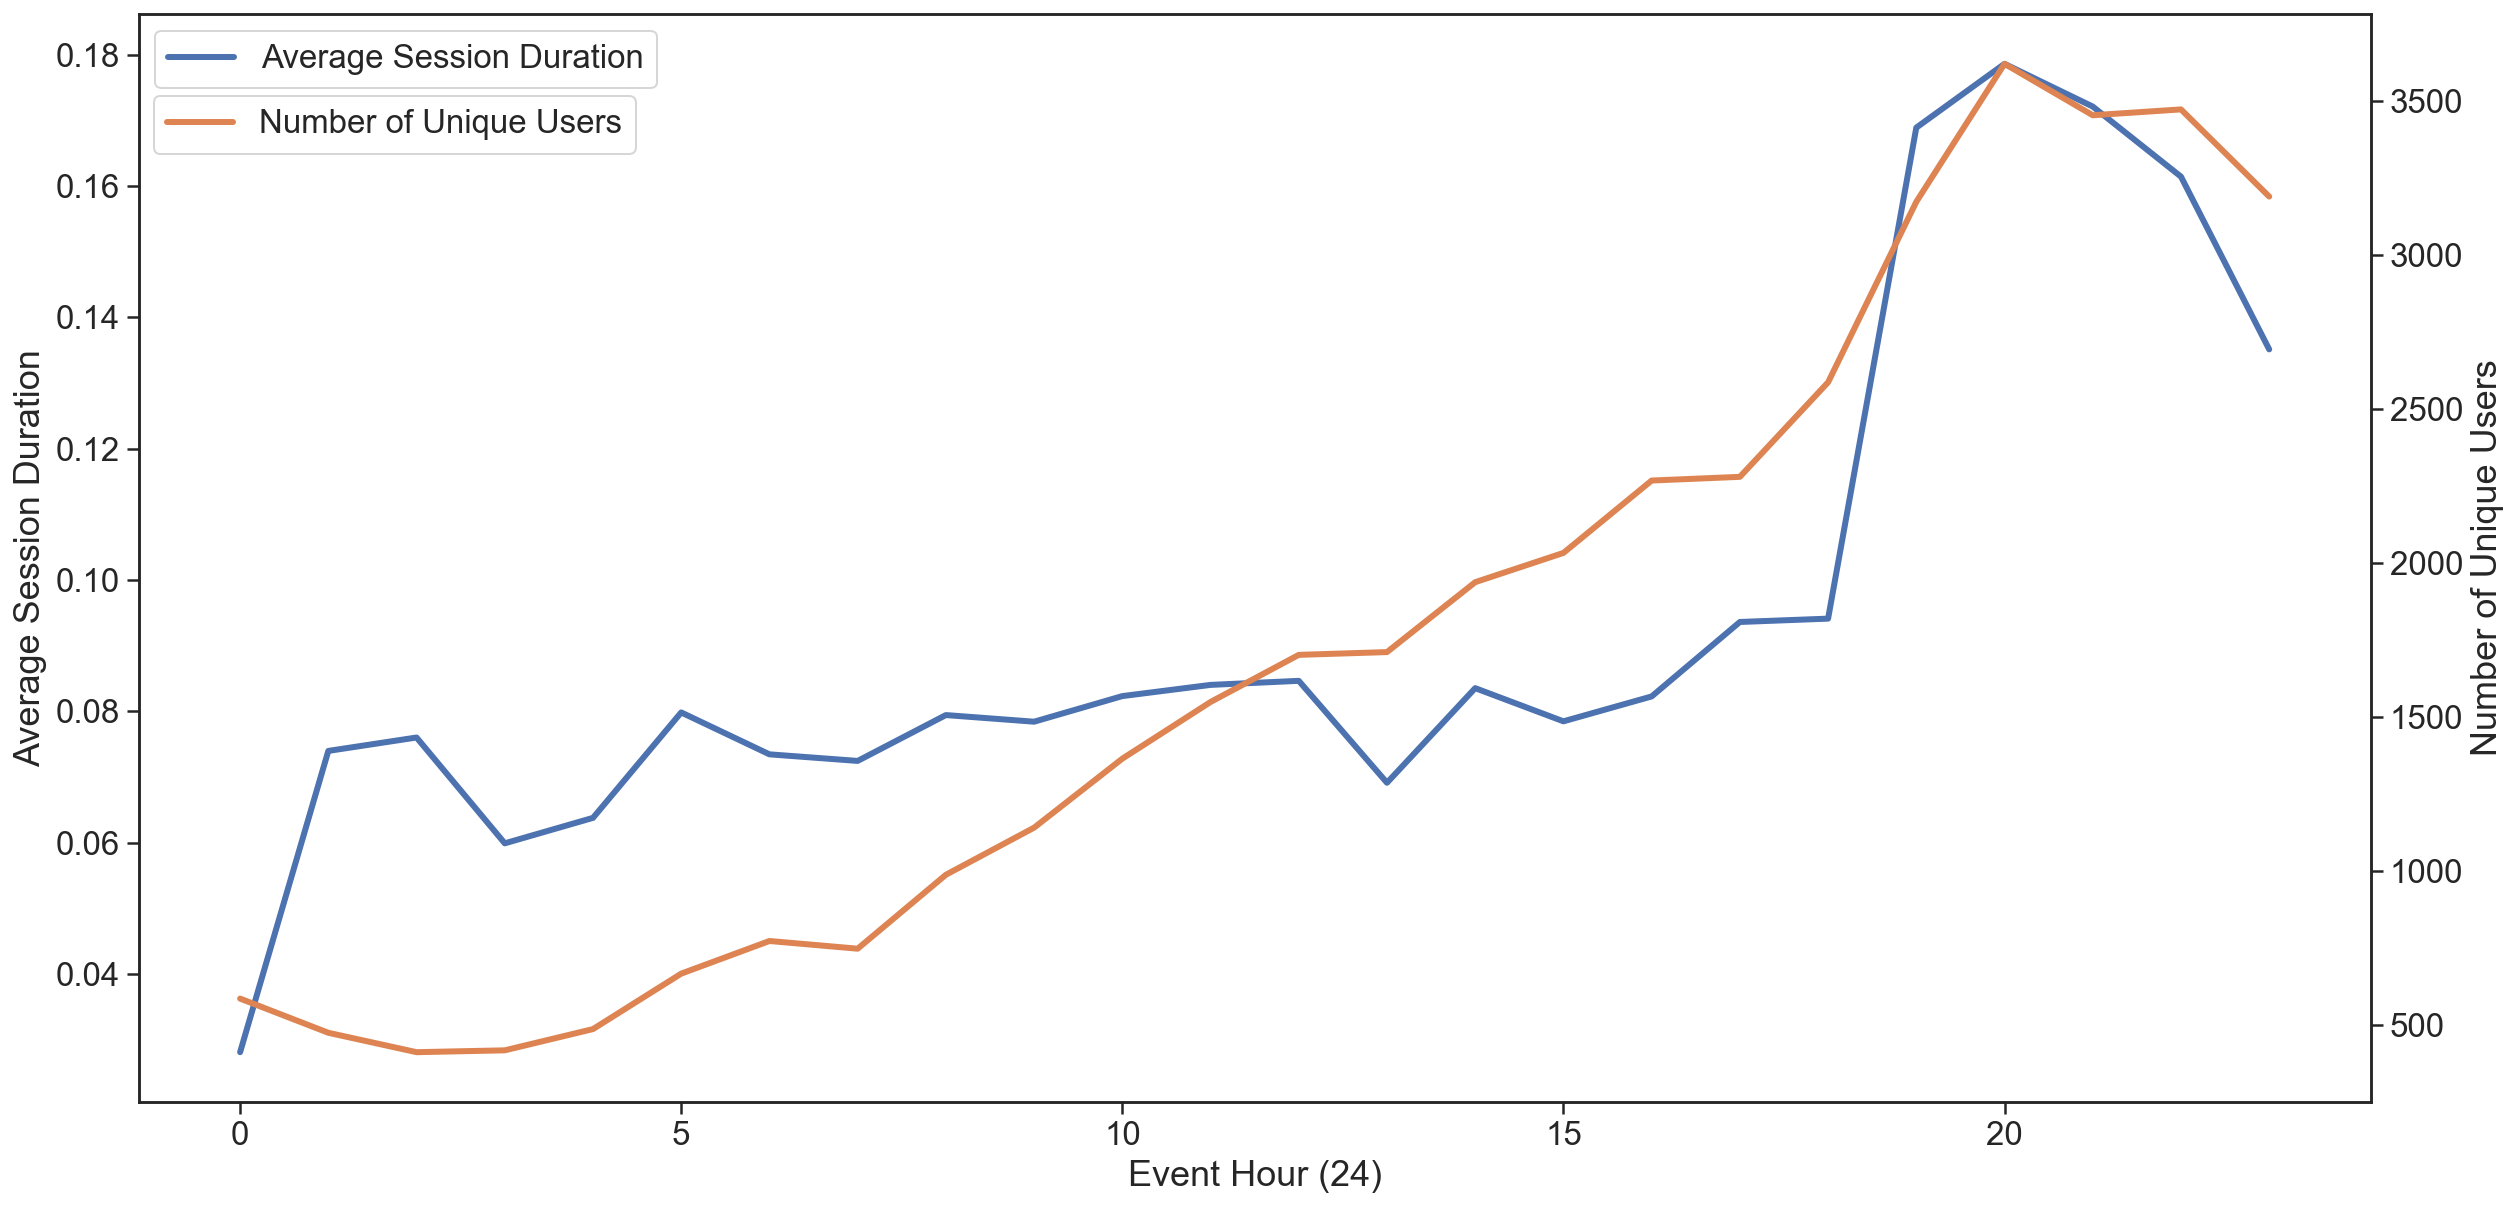

In [5]:
plot_duration_vs_users("Overall")

---

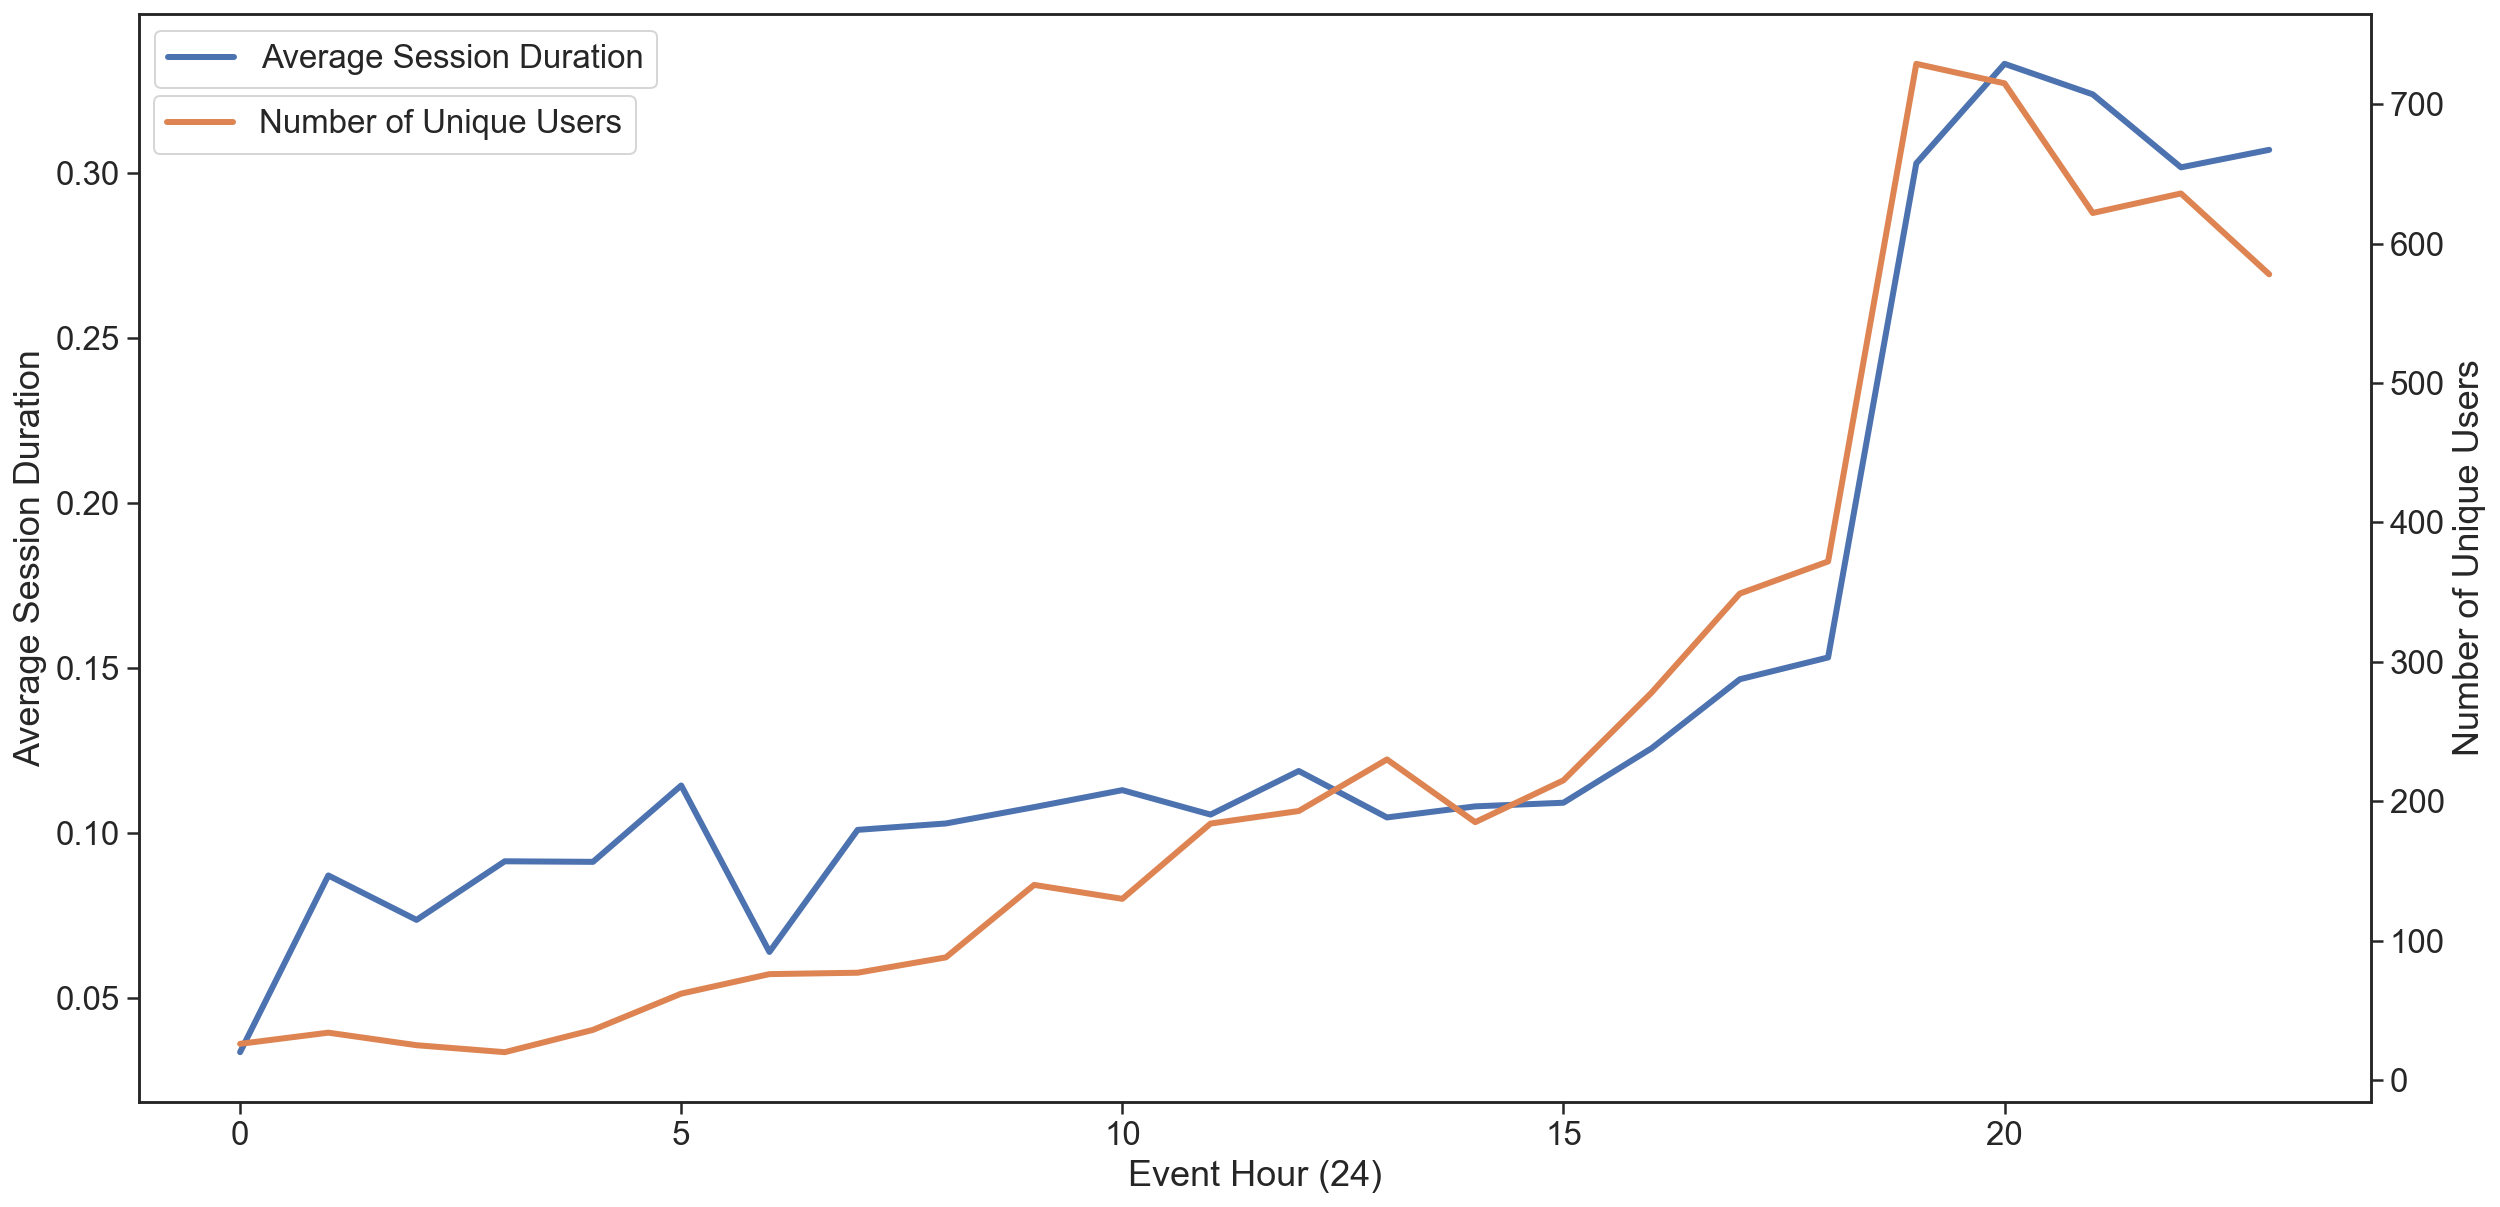

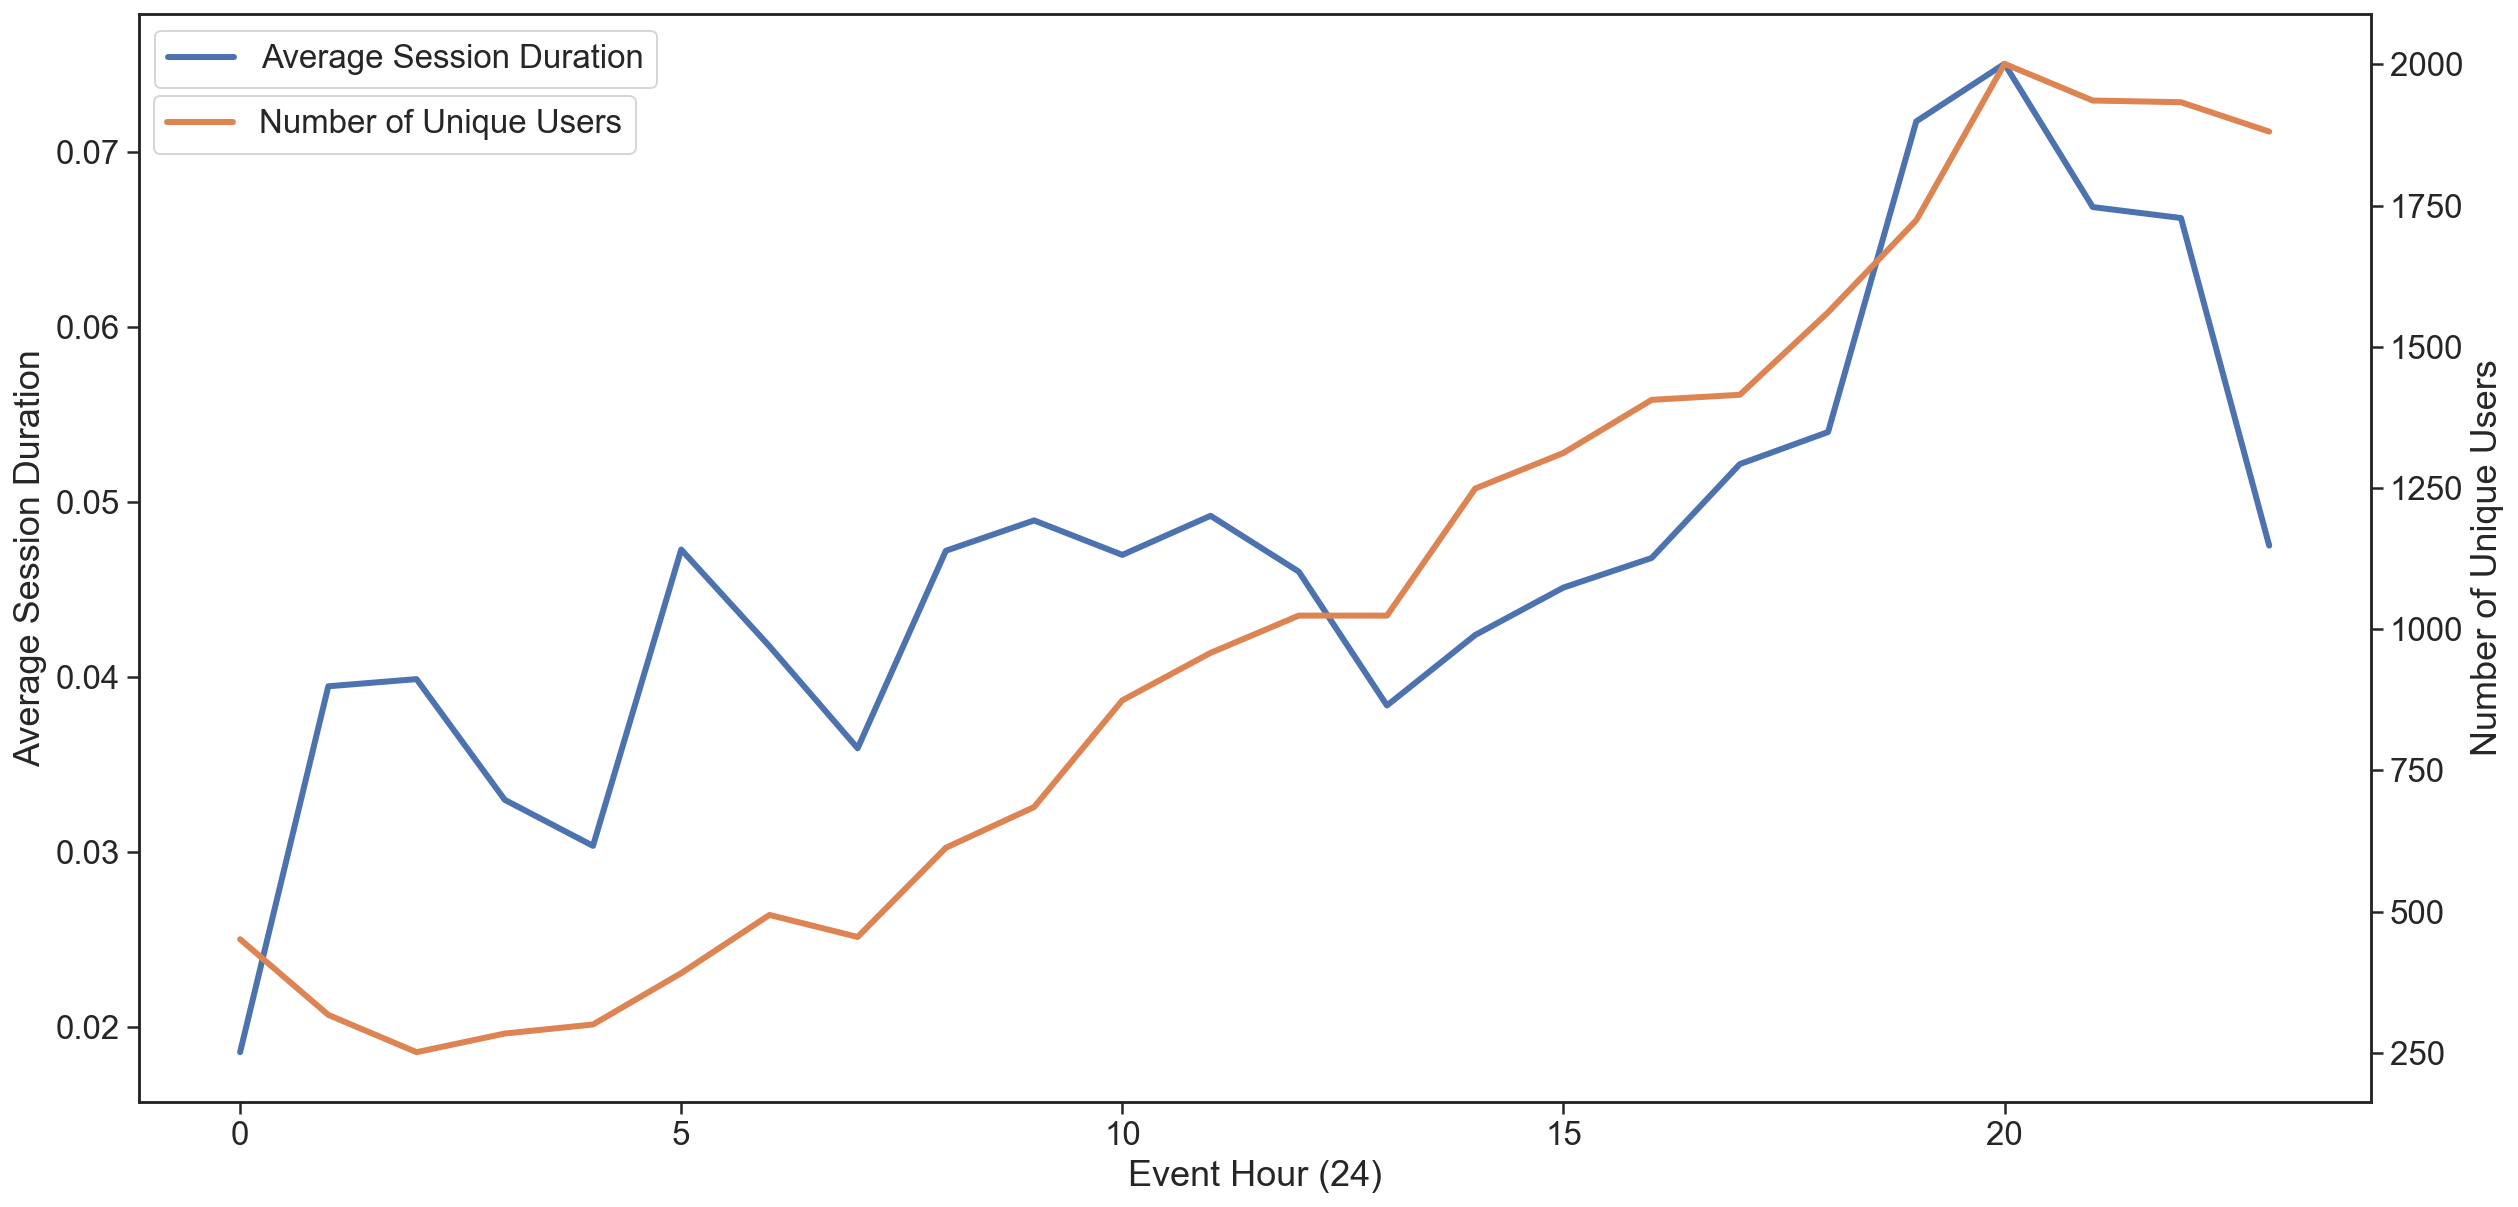

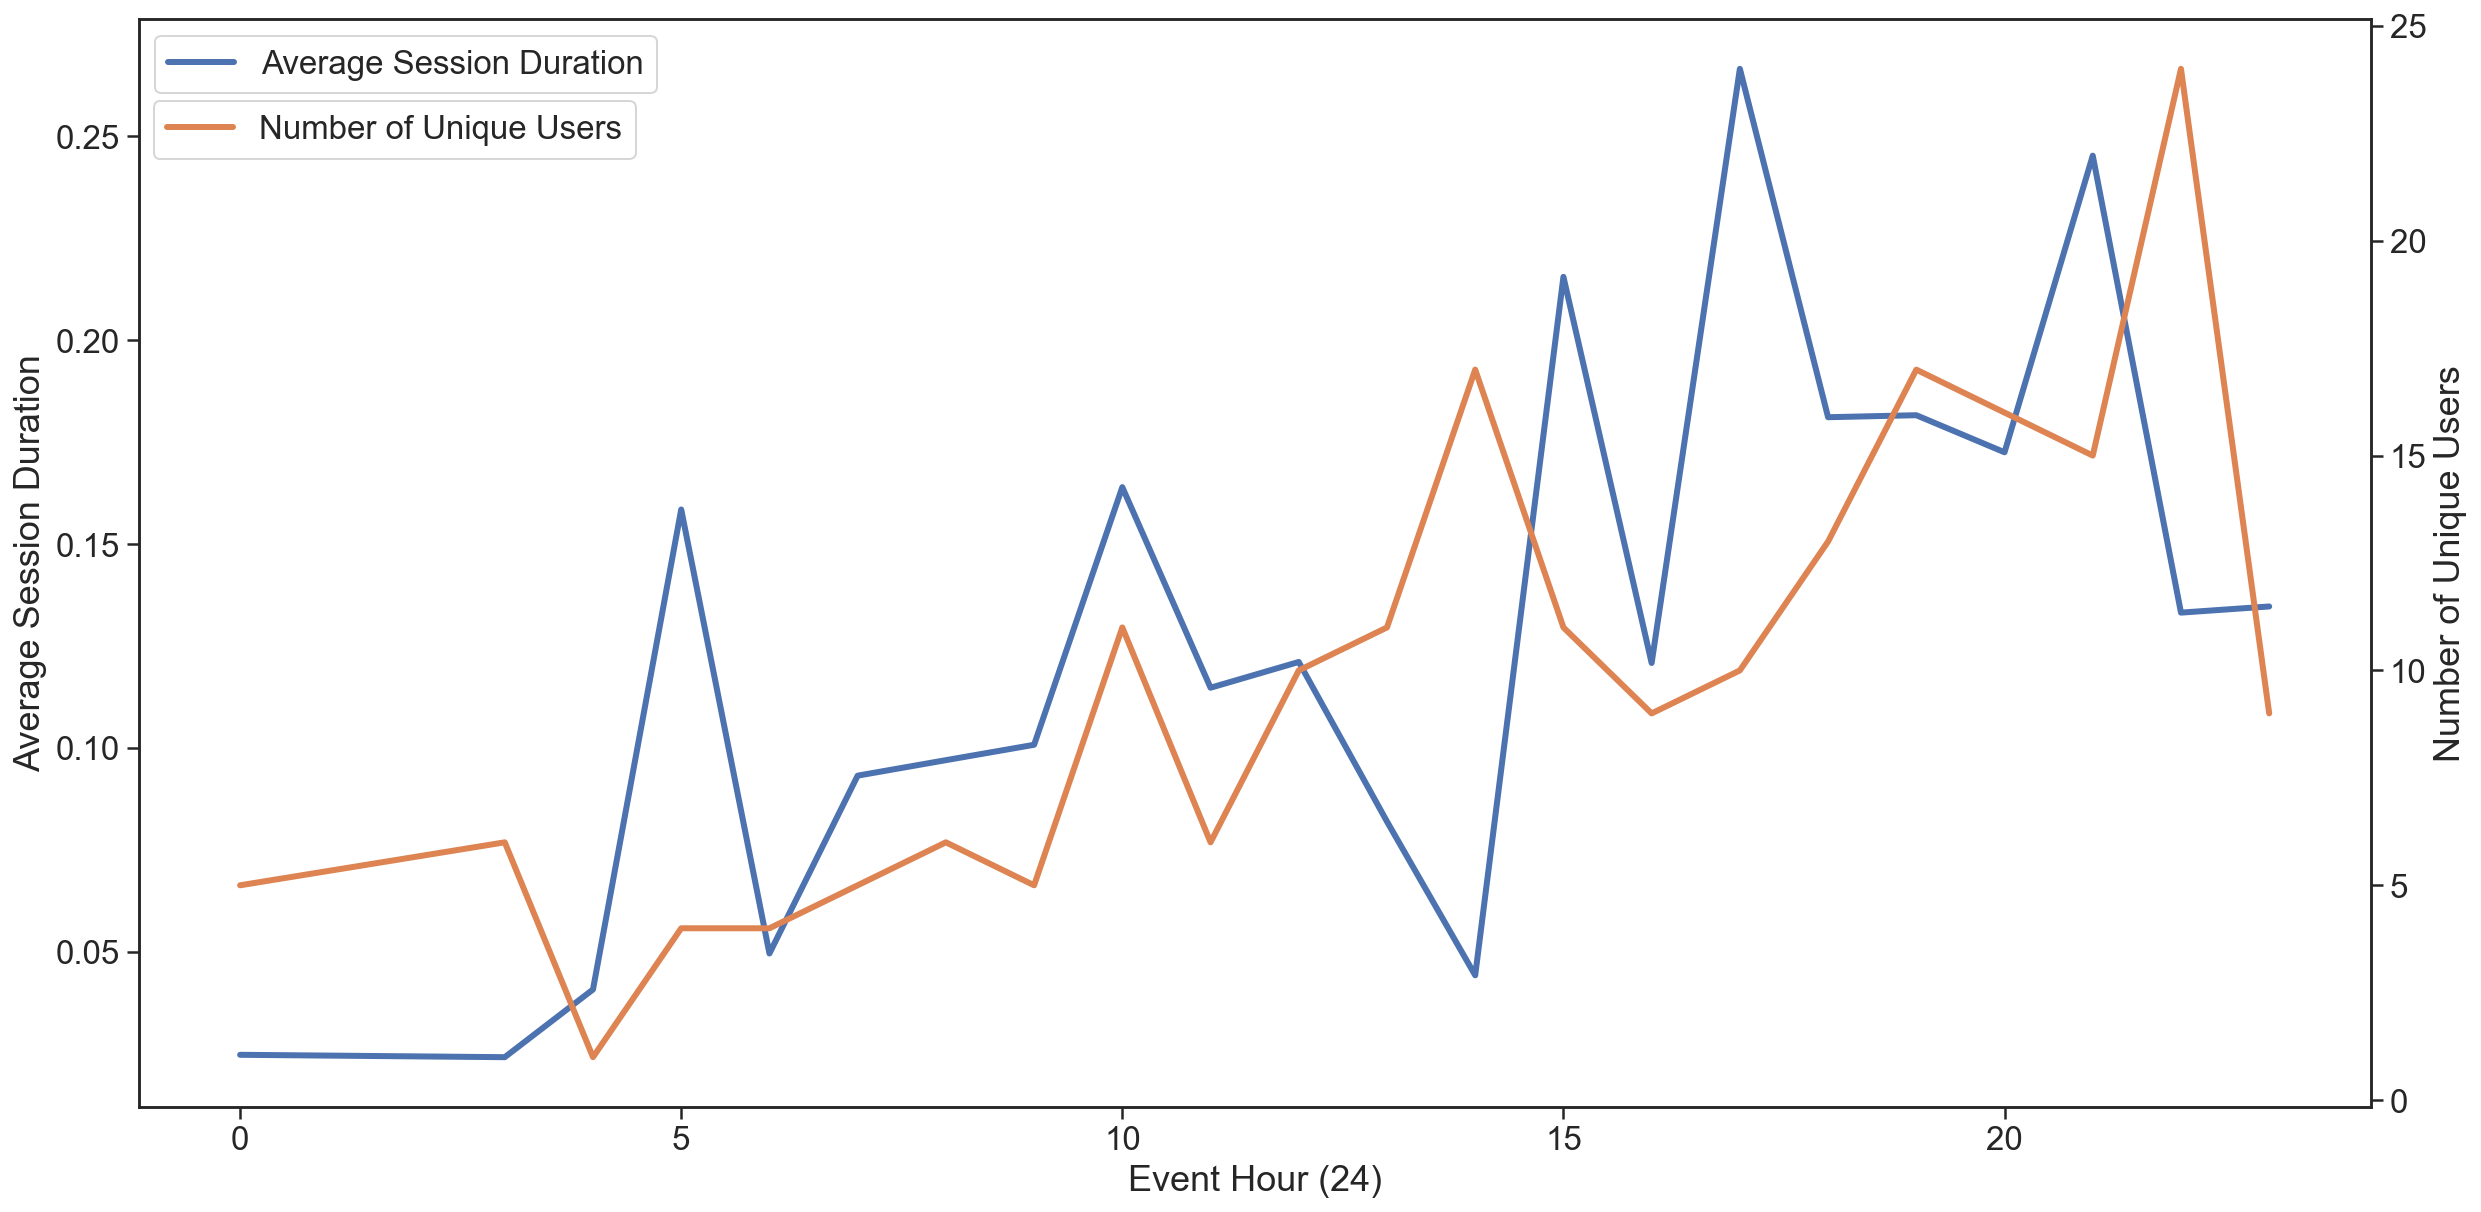

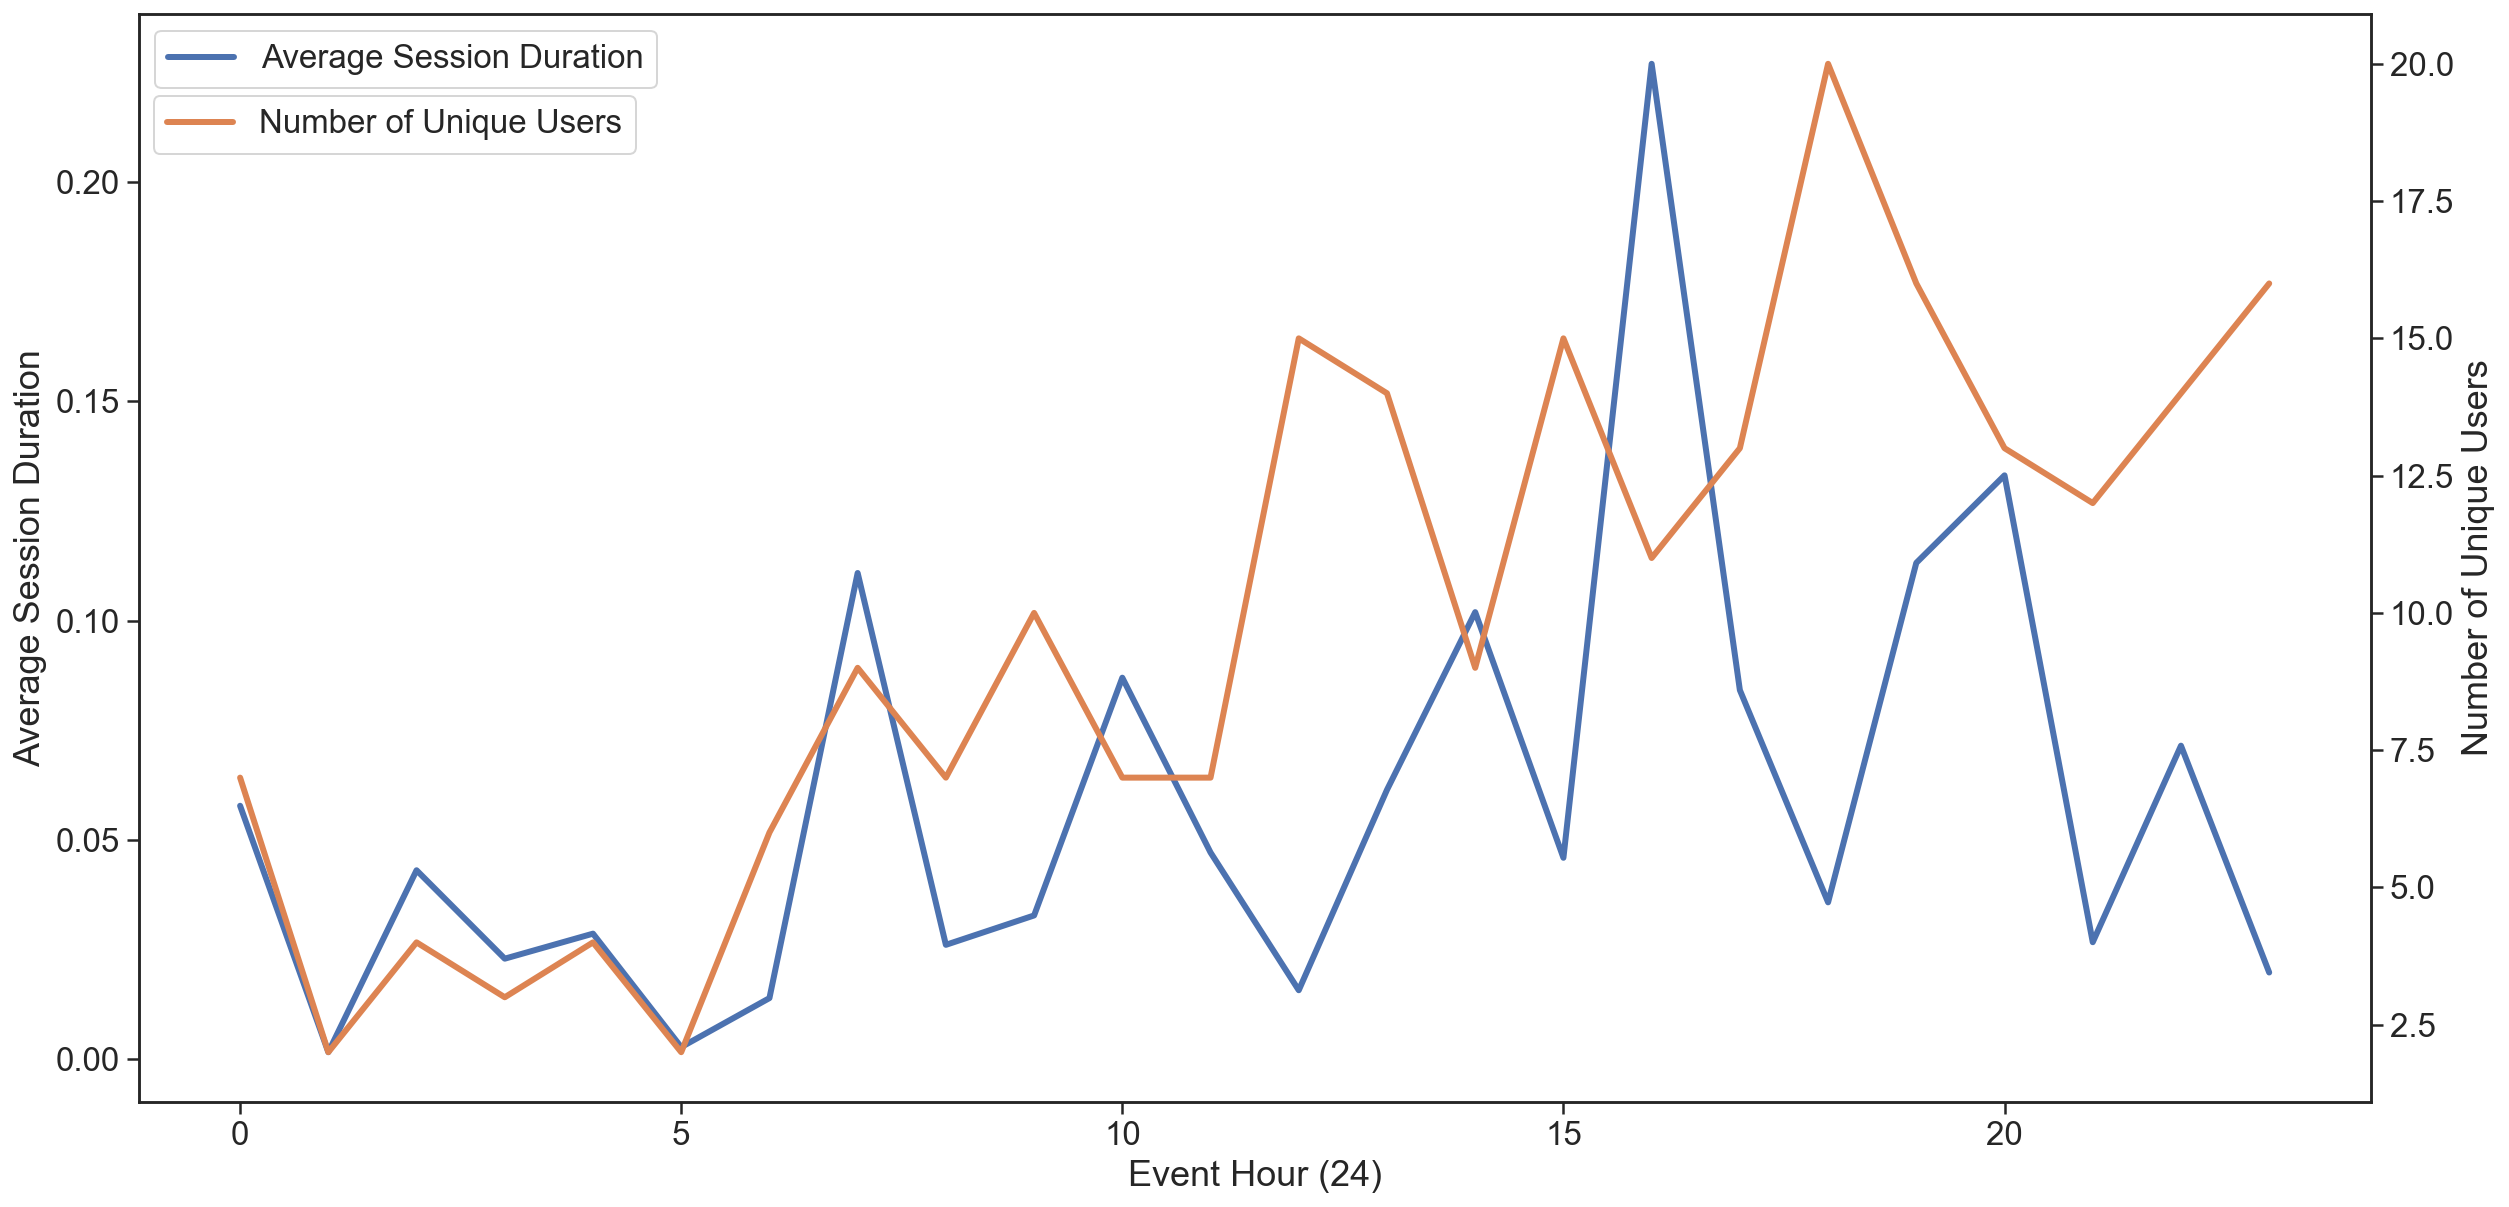

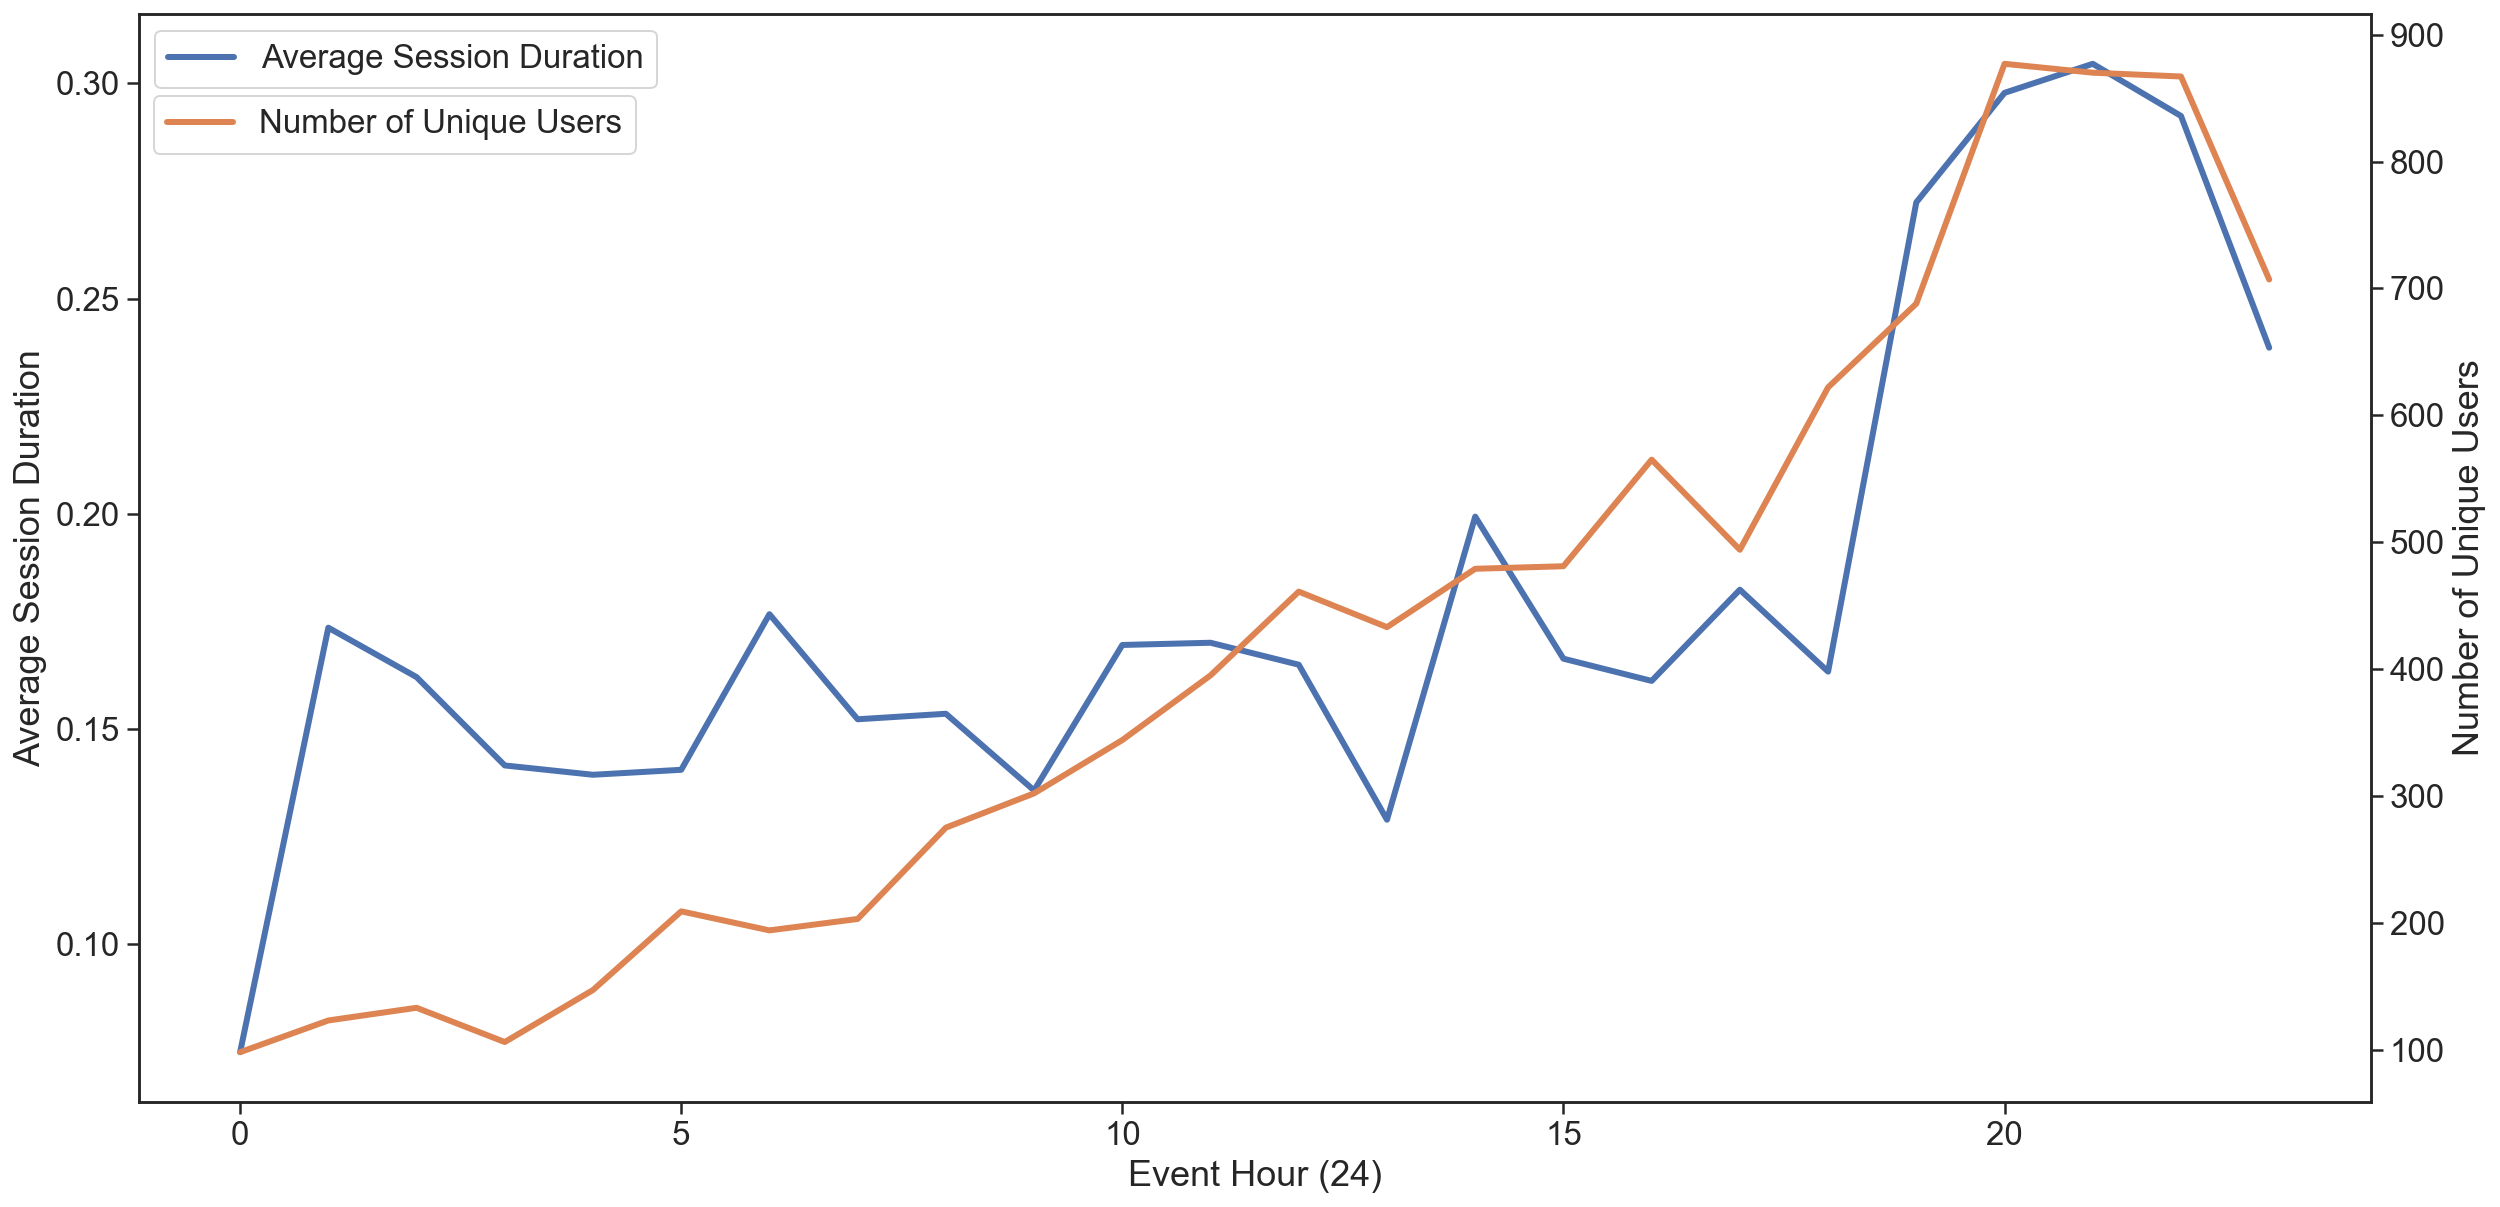

In [6]:
for name in table_names:
    plot_duration_vs_users(name)

---

In [7]:
df = pandas.read_sql("SELECT event_time, query, media_types FROM keyword_search WHERE session_duration != 0",
                     connection, parse_dates={"event_time" : "%H:%M"})
df["event_hour"] = df["event_time"].dt.hour
del df["event_time"]

# The original media_types remain in the database so that we can see how many users requested "all" or some
# combination.  Here I erred on the side of, if someone were to ask me, "How many photos of Joe Biden were requested
# yesterday?", splitting "all" and the multiple media types up answers that question.
multi_media = df.query('media_types.str.contains(",") | media_types == "all"').copy()
df = df[~df.index.isin(multi_media.index)].copy()
for (i, row) in multi_media.iterrows():
    if "," in row["media_types"]:
        new_rows = [{"query" : row["query"], "event_hour" : row["event_hour"], "media_types" : m}
                     for m in row["media_types"].split(",")]
    else:
        new_rows = [{"query" : row["query"], "event_hour" : row["event_hour"], "media_types" : m}
                    for m in ["photo", "video", "text", "graphic", "audio"]]
    df = df.append(new_rows, ignore_index=True)

# More normalization can be done here (e.g. remove " (state)" from queries so that "florida" and "florida (state)")
# count as the same query).
df["query"] = df["query"].apply(str.lower)
df["query"] = df["query"].apply(lambda x : re.sub(r'["\\]+', "", x).strip())
df["query"] = df["query"].apply(lambda x : ("joe biden" if x == "biden" else
                                           ("donald trump" if x == "trump" else x)))

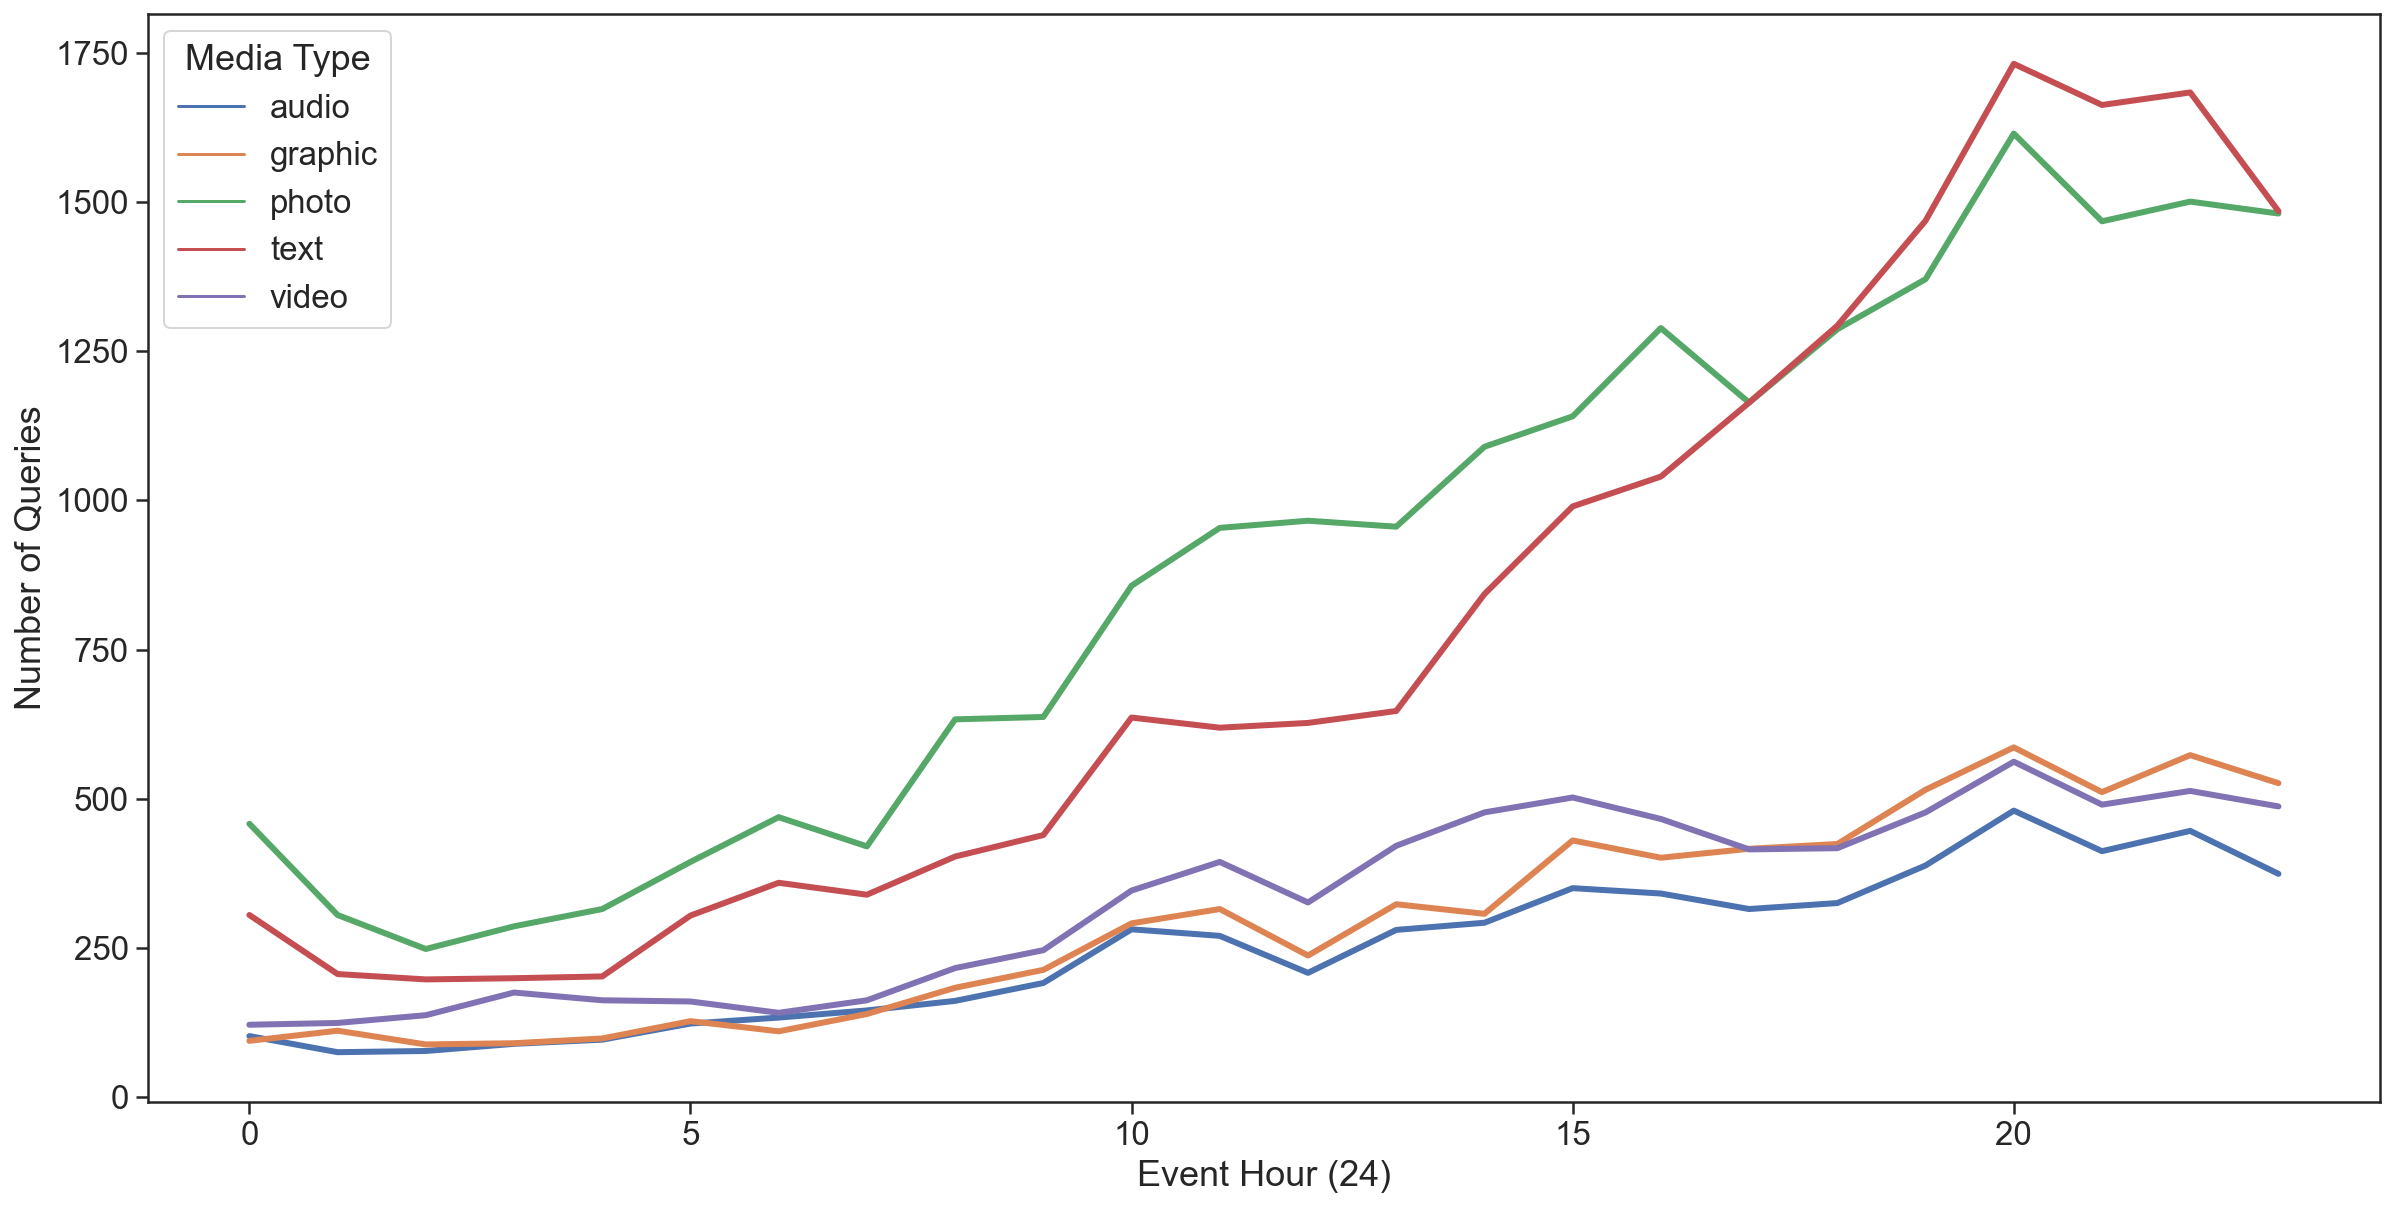

In [8]:
media = df.groupby(["media_types", "event_hour"]).size().reset_index()
media = media.rename(columns={0 : "count"})
ax = sns.lineplot(data=media, x="event_hour", y="count", hue="media_types", linewidth=3)
ax.set(xlabel="Event Hour (24)", ylabel="Number of Queries")
ax.get_legend().set_title("Media Type")
plt.show()

In [9]:
top_10 = df.groupby(["query"]).size().reset_index().sort_values(by=0, ascending=False)[0:10]
top_10

,query,0
2752,donald trump,2857
4957,joe biden,2197
2969,election,1226
4626,indiana,462
9620,vienna,461
3720,florida,412
9391,us election,407
2971,election 2020,366
2952,elecciones,356
4547,illinois,350


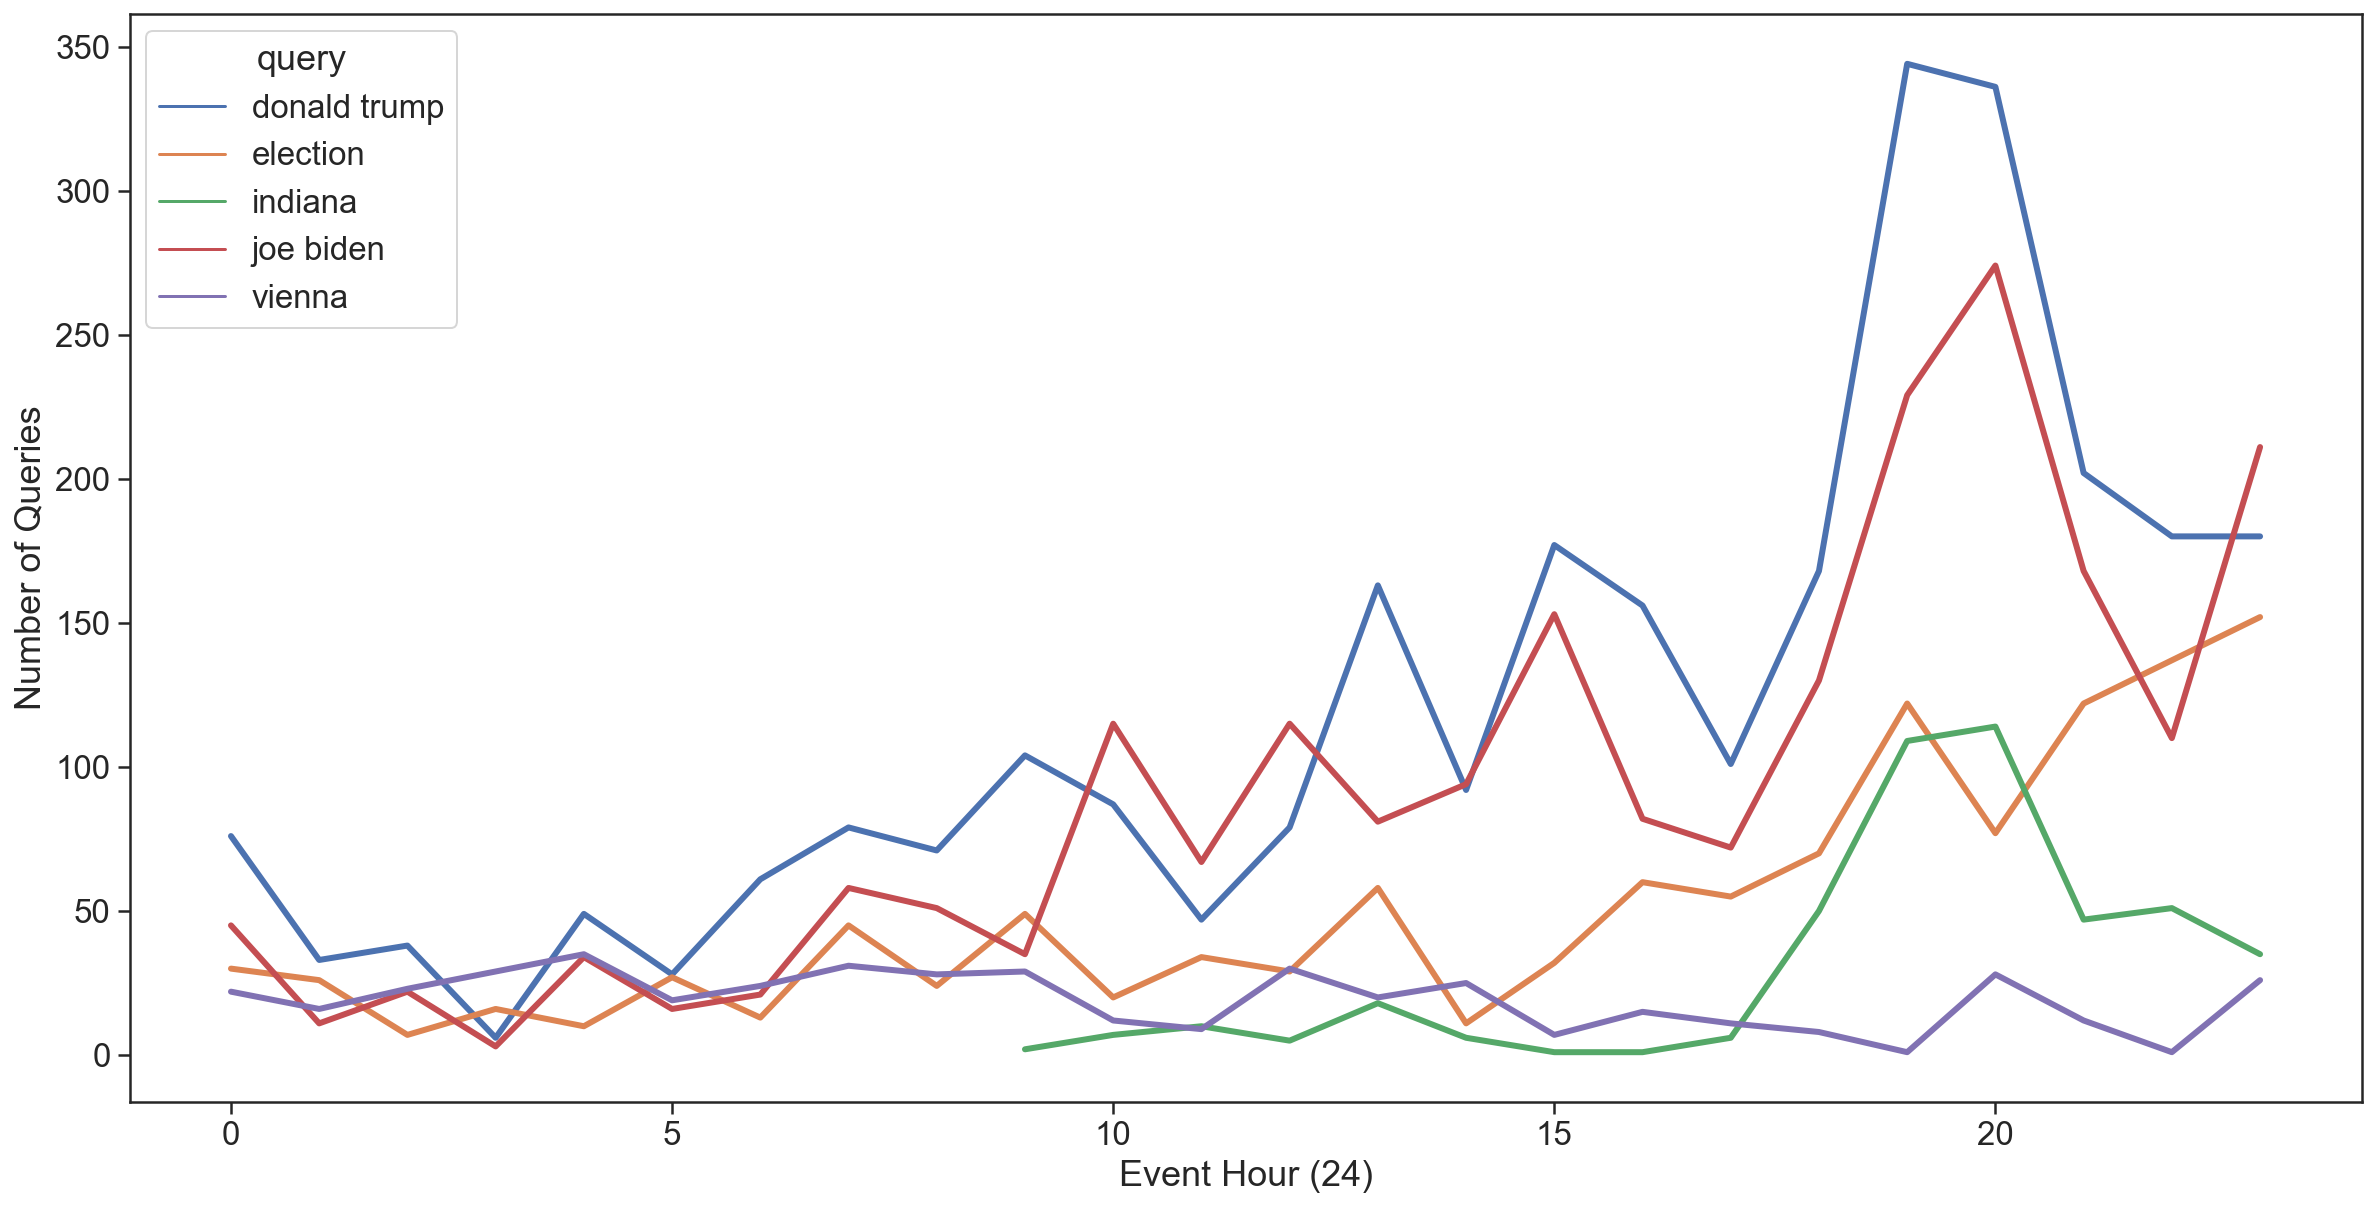

In [10]:
top_5_per_hour = df[df["query"].isin(top_10["query"][0:5])].groupby(["query", "event_hour"]).size().reset_index()
top_5_per_hour = top_5_per_hour.rename(columns={0 : "count"})
ax = sns.lineplot(data=top_5_per_hour, x="event_hour", y="count", hue="query", linewidth=3)
ax.set(xlabel="Event Hour (24)", ylabel="Number of Queries")
plt.show()

---

In [11]:
df = pandas.read_sql("SELECT event_time, event_label, event_category, retrievals_count FROM content_retrievals",
                     connection, parse_dates={"event_time" : "%H:%M"})
df["event_hour"] = df["event_time"].dt.hour
del df["event_time"]

In [12]:
top_10 = df.groupby(["event_label"]).agg({"retrievals_count" : "sum"}).reset_index().sort_values(
    by="retrievals_count", ascending=False)[0:10]
top_10

,event_label,retrievals_count
2863,US--Election 2020-The Latest,519
2838,US--Election 2020,342
1394,Election 2020 Trump,157
1182,Election 2020 Biden,146
2834,US--APNewsAlert,142
2856,US--Election 2020-Senate,127
2869,US--Election 2020-Voting,97
2861,US--Election 2020-Senate-The Latest,88
1914,LT--Tropical Weather,72
2943,US--Virus-Outbreak,63


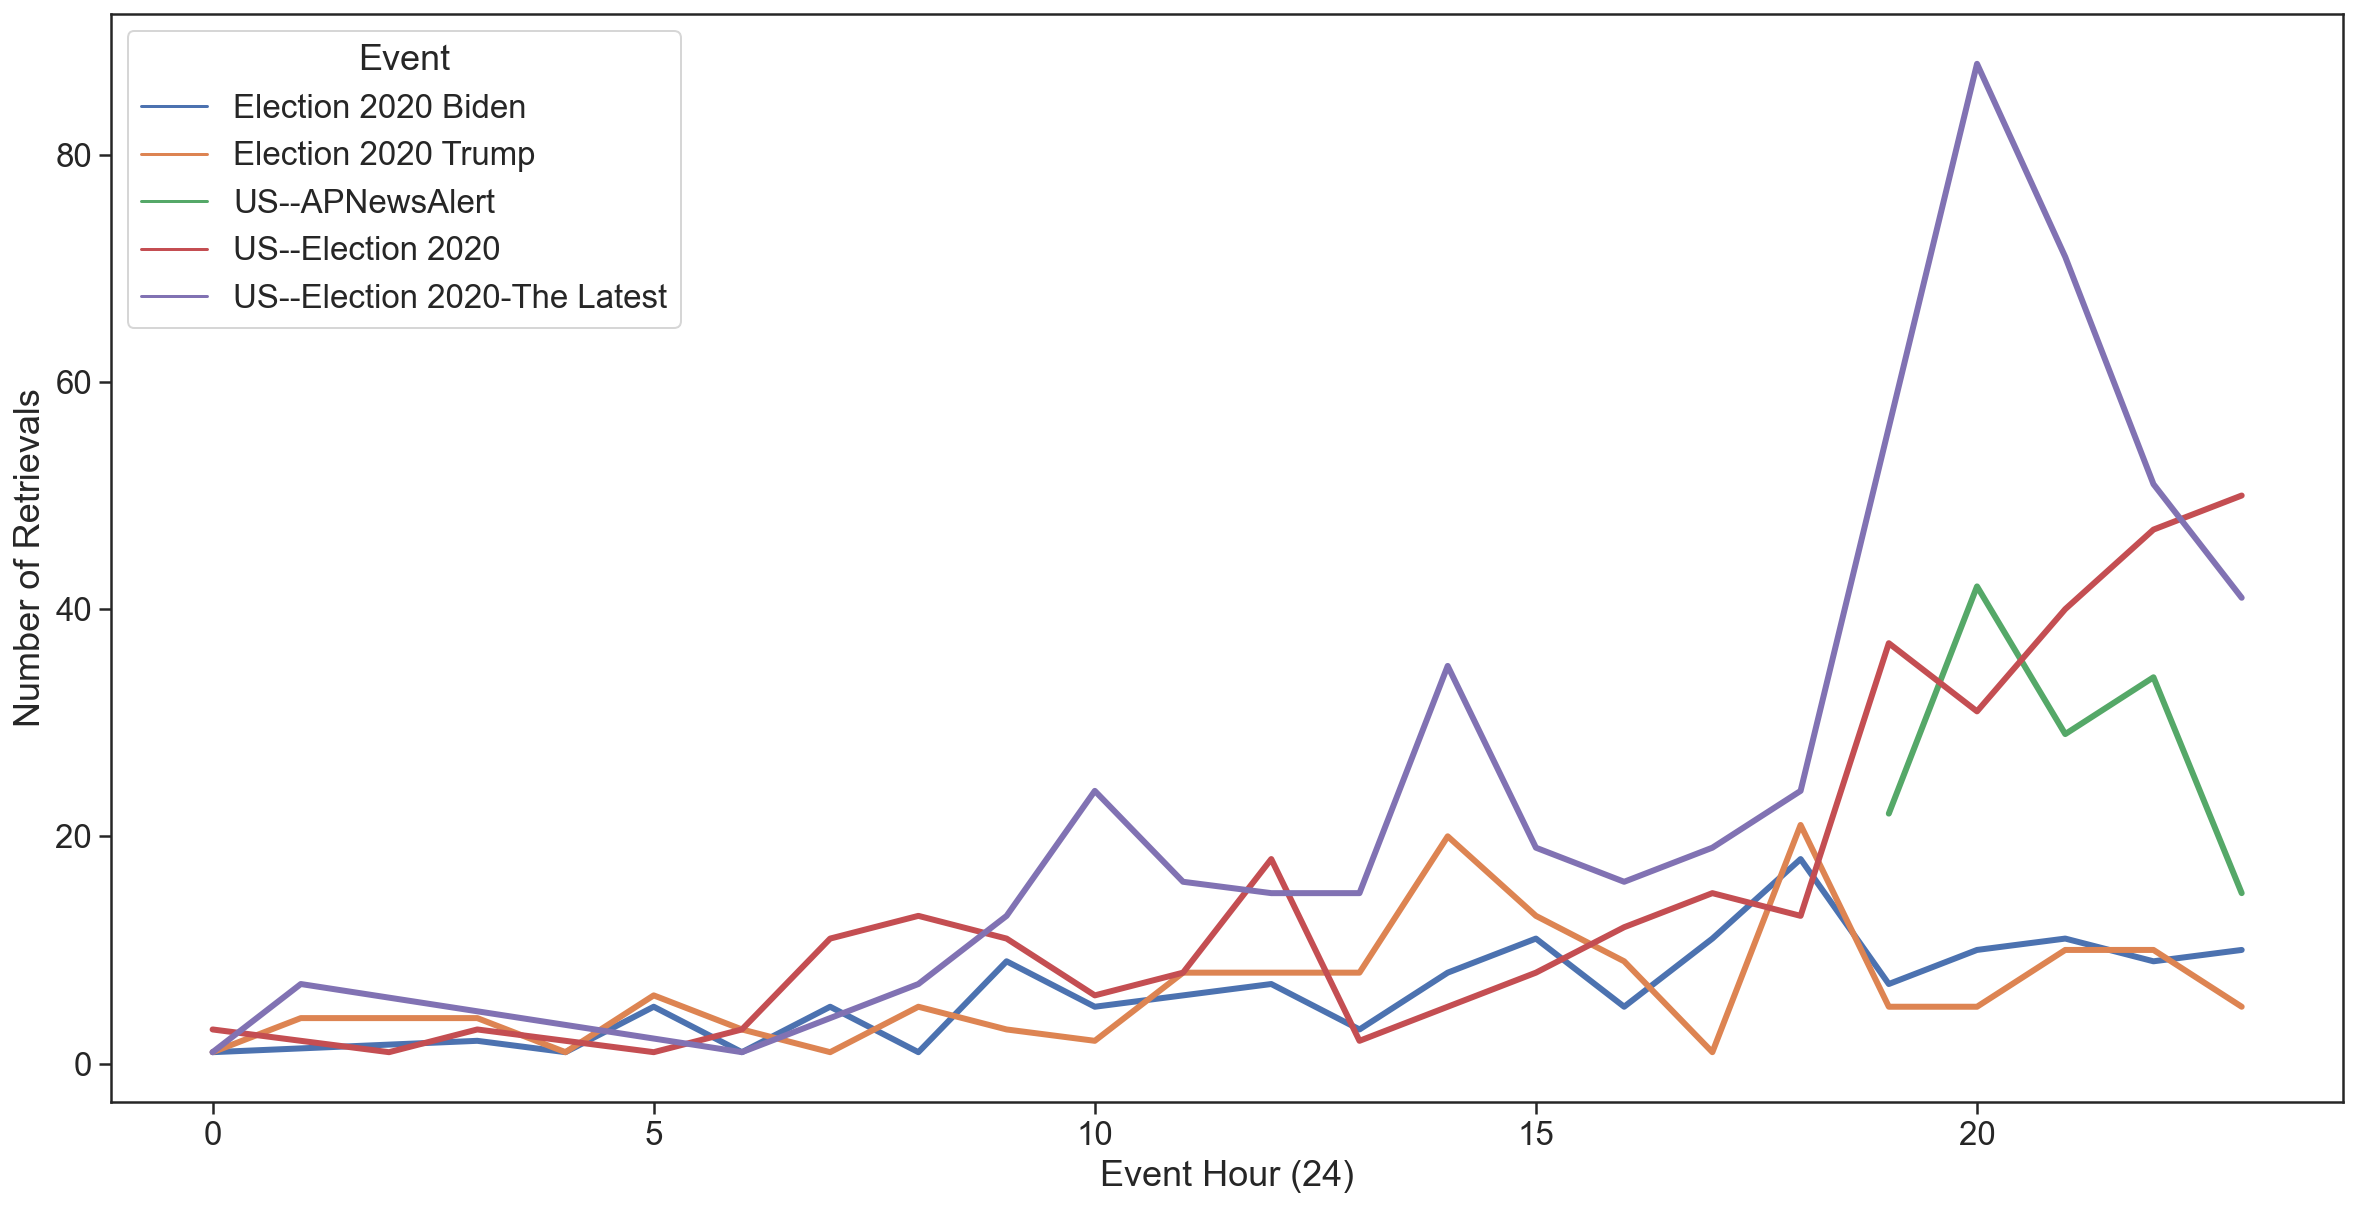

In [13]:
top_5_per_hour = df[df["event_label"].isin(
    top_10["event_label"][0:5])].groupby(["event_label", "event_hour"]).agg(
    {"retrievals_count" : "sum"}).reset_index()
ax = sns.lineplot(data=top_5_per_hour, x="event_hour", y="retrievals_count", hue="event_label", linewidth=3)
ax.set(xlabel="Event Hour (24)", ylabel="Number of Retrievals")
ax.get_legend().set_title("Event")
plt.show()

---

In [14]:
df = pandas.read_sql("SELECT event_time, event_label, event_category FROM content_preview",
                     connection, parse_dates={"event_time" : "%H:%M"})
df["event_hour"] = df["event_time"].dt.hour
del df["event_time"]

In [15]:
top_10 = df.groupby(["event_label"]).size().reset_index().sort_values(by=0, ascending=False)[0:10]
top_10

,event_label,0
114,US--Election 2020-The Latest,24
105,US--Election 2020,15
23,Body Only,7
104,US--APNewsAlert,6
112,US--Election 2020-Senate,6
61,LT--Tropical Weather,5
117,US--Election 2020-Voting,4
0,(not set),4
106,US--Election 2020-Dixville Notch,3
132,US--Supreme Court-Juvenile Life in Prison,3


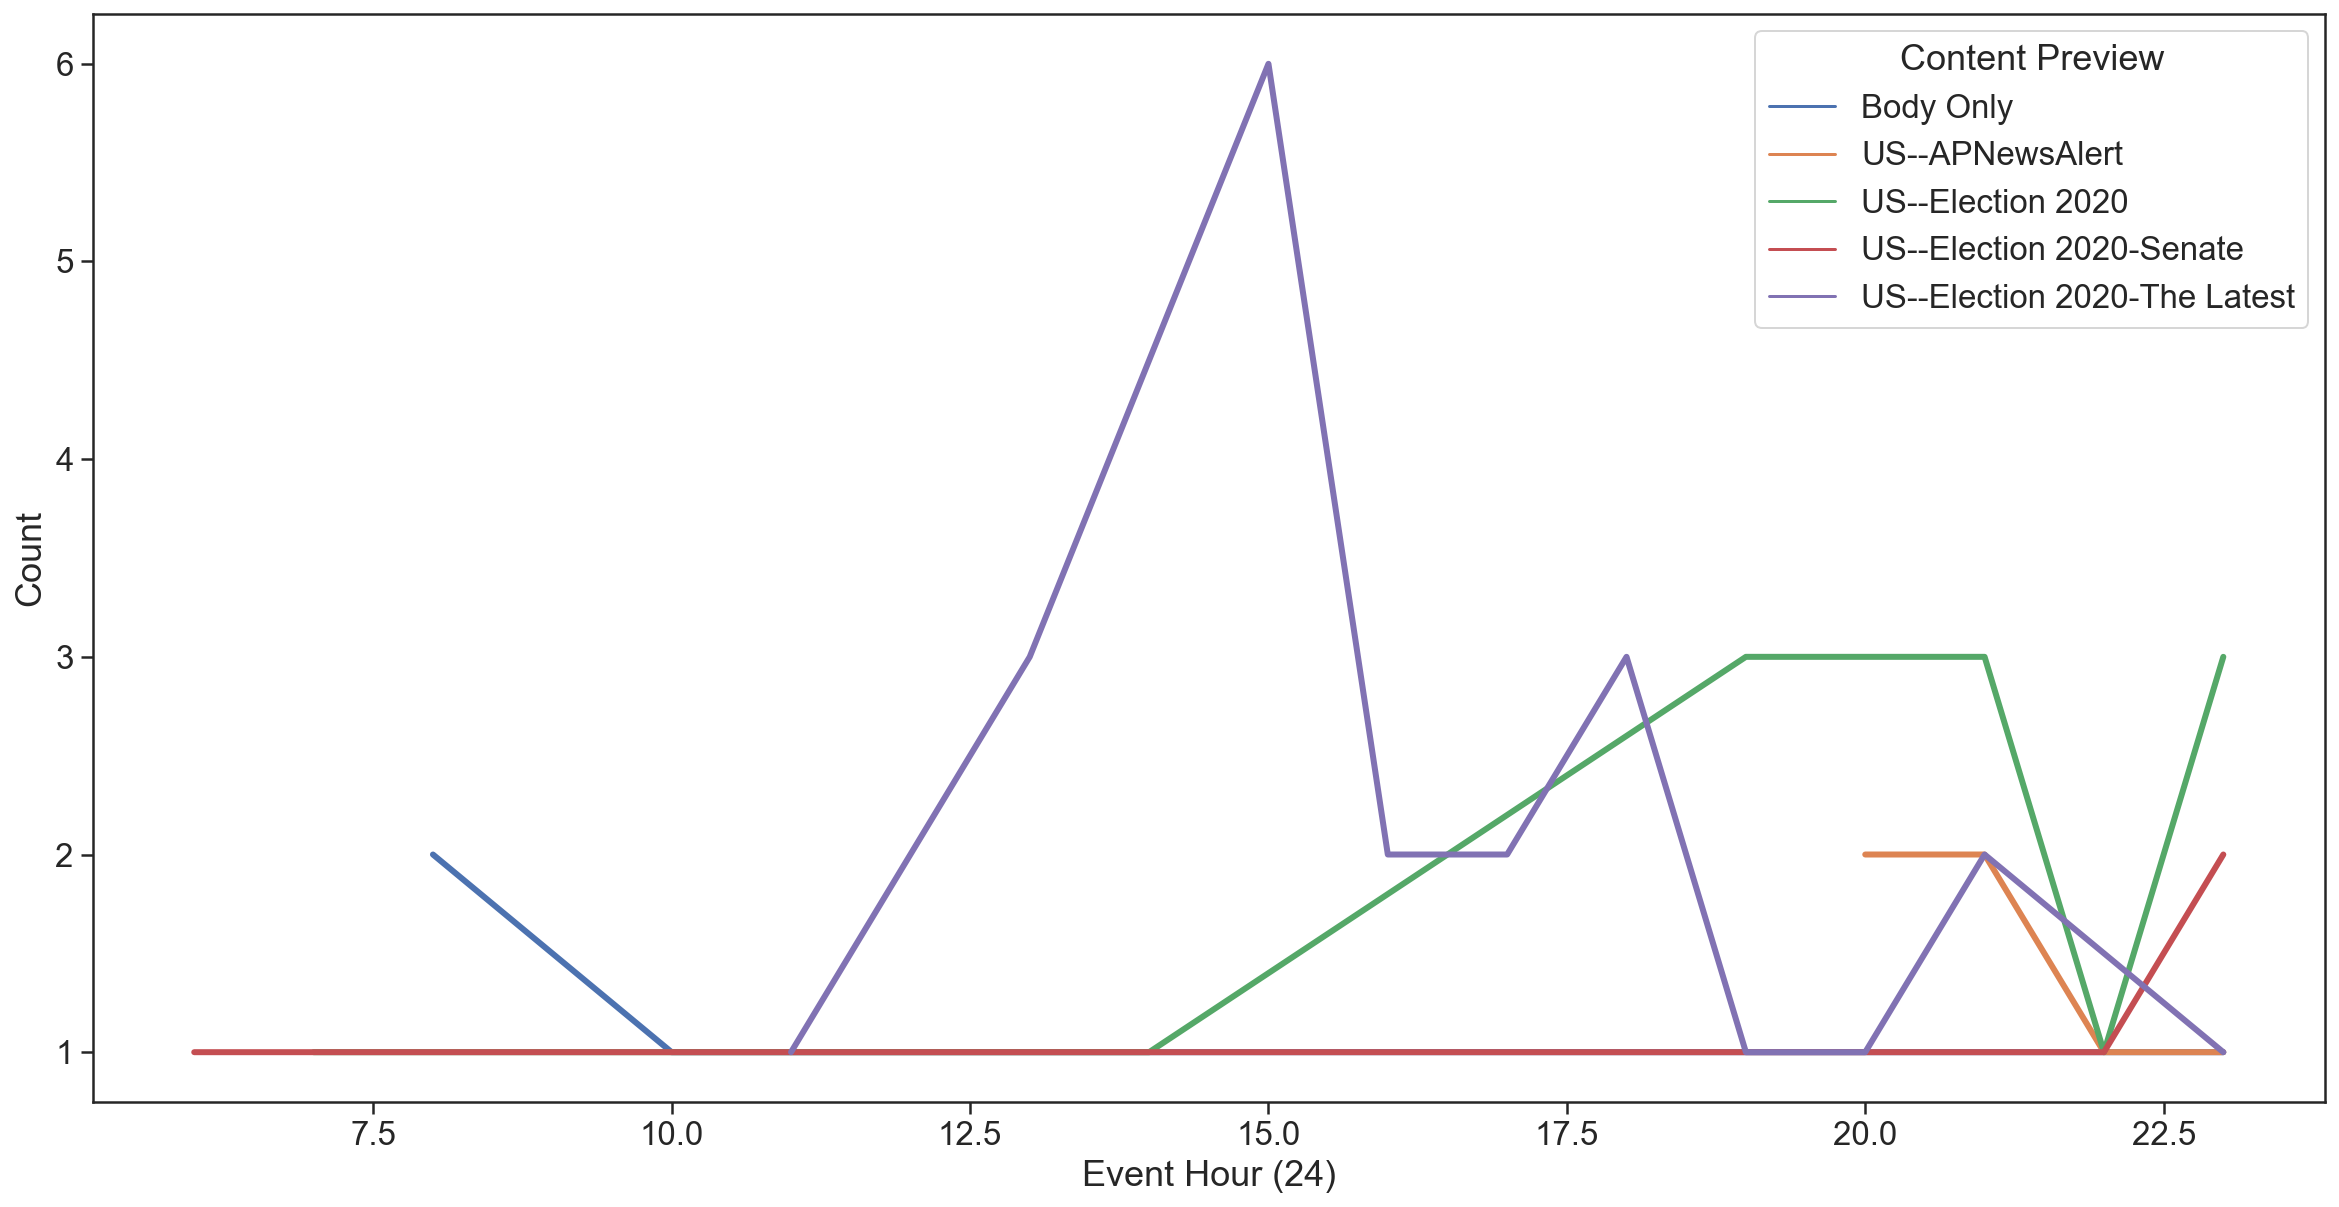

In [16]:
previews = df[df["event_label"].isin(top_10["event_label"][0:5])].groupby(
    ["event_label", "event_hour"]).size().reset_index()
previews = previews.rename(columns={0 : "count"})
ax = sns.lineplot(data=previews, x="event_hour", y="count", hue="event_label", linewidth=3)
ax.set(xlabel="Event Hour (24)", ylabel="Count")
ax.get_legend().set_title("Content Preview")
plt.show()

---

In [17]:
df = pandas.read_sql("SELECT event_time, event_label FROM browse_navigation", connection,
                     parse_dates={"event_time" : "%H:%M"})
df["event_hour"] = df["event_time"].dt.hour
del df["event_time"]

In [18]:
top_10 = df.groupby(["event_label"]).size().reset_index().sort_values(by=0, ascending=False)[0:10]
top_10

,event_label,0
155,Top News,1054
164,U.S. Election 2020,895
0,(not set),785
23,All Newest Stories,387
110,News Alerts,349
3,AP News Alerts (2020 Election),343
136,Sports,305
178,VoteCast Coverage,223
163,U.S.,207
47,Election Top Stories,172


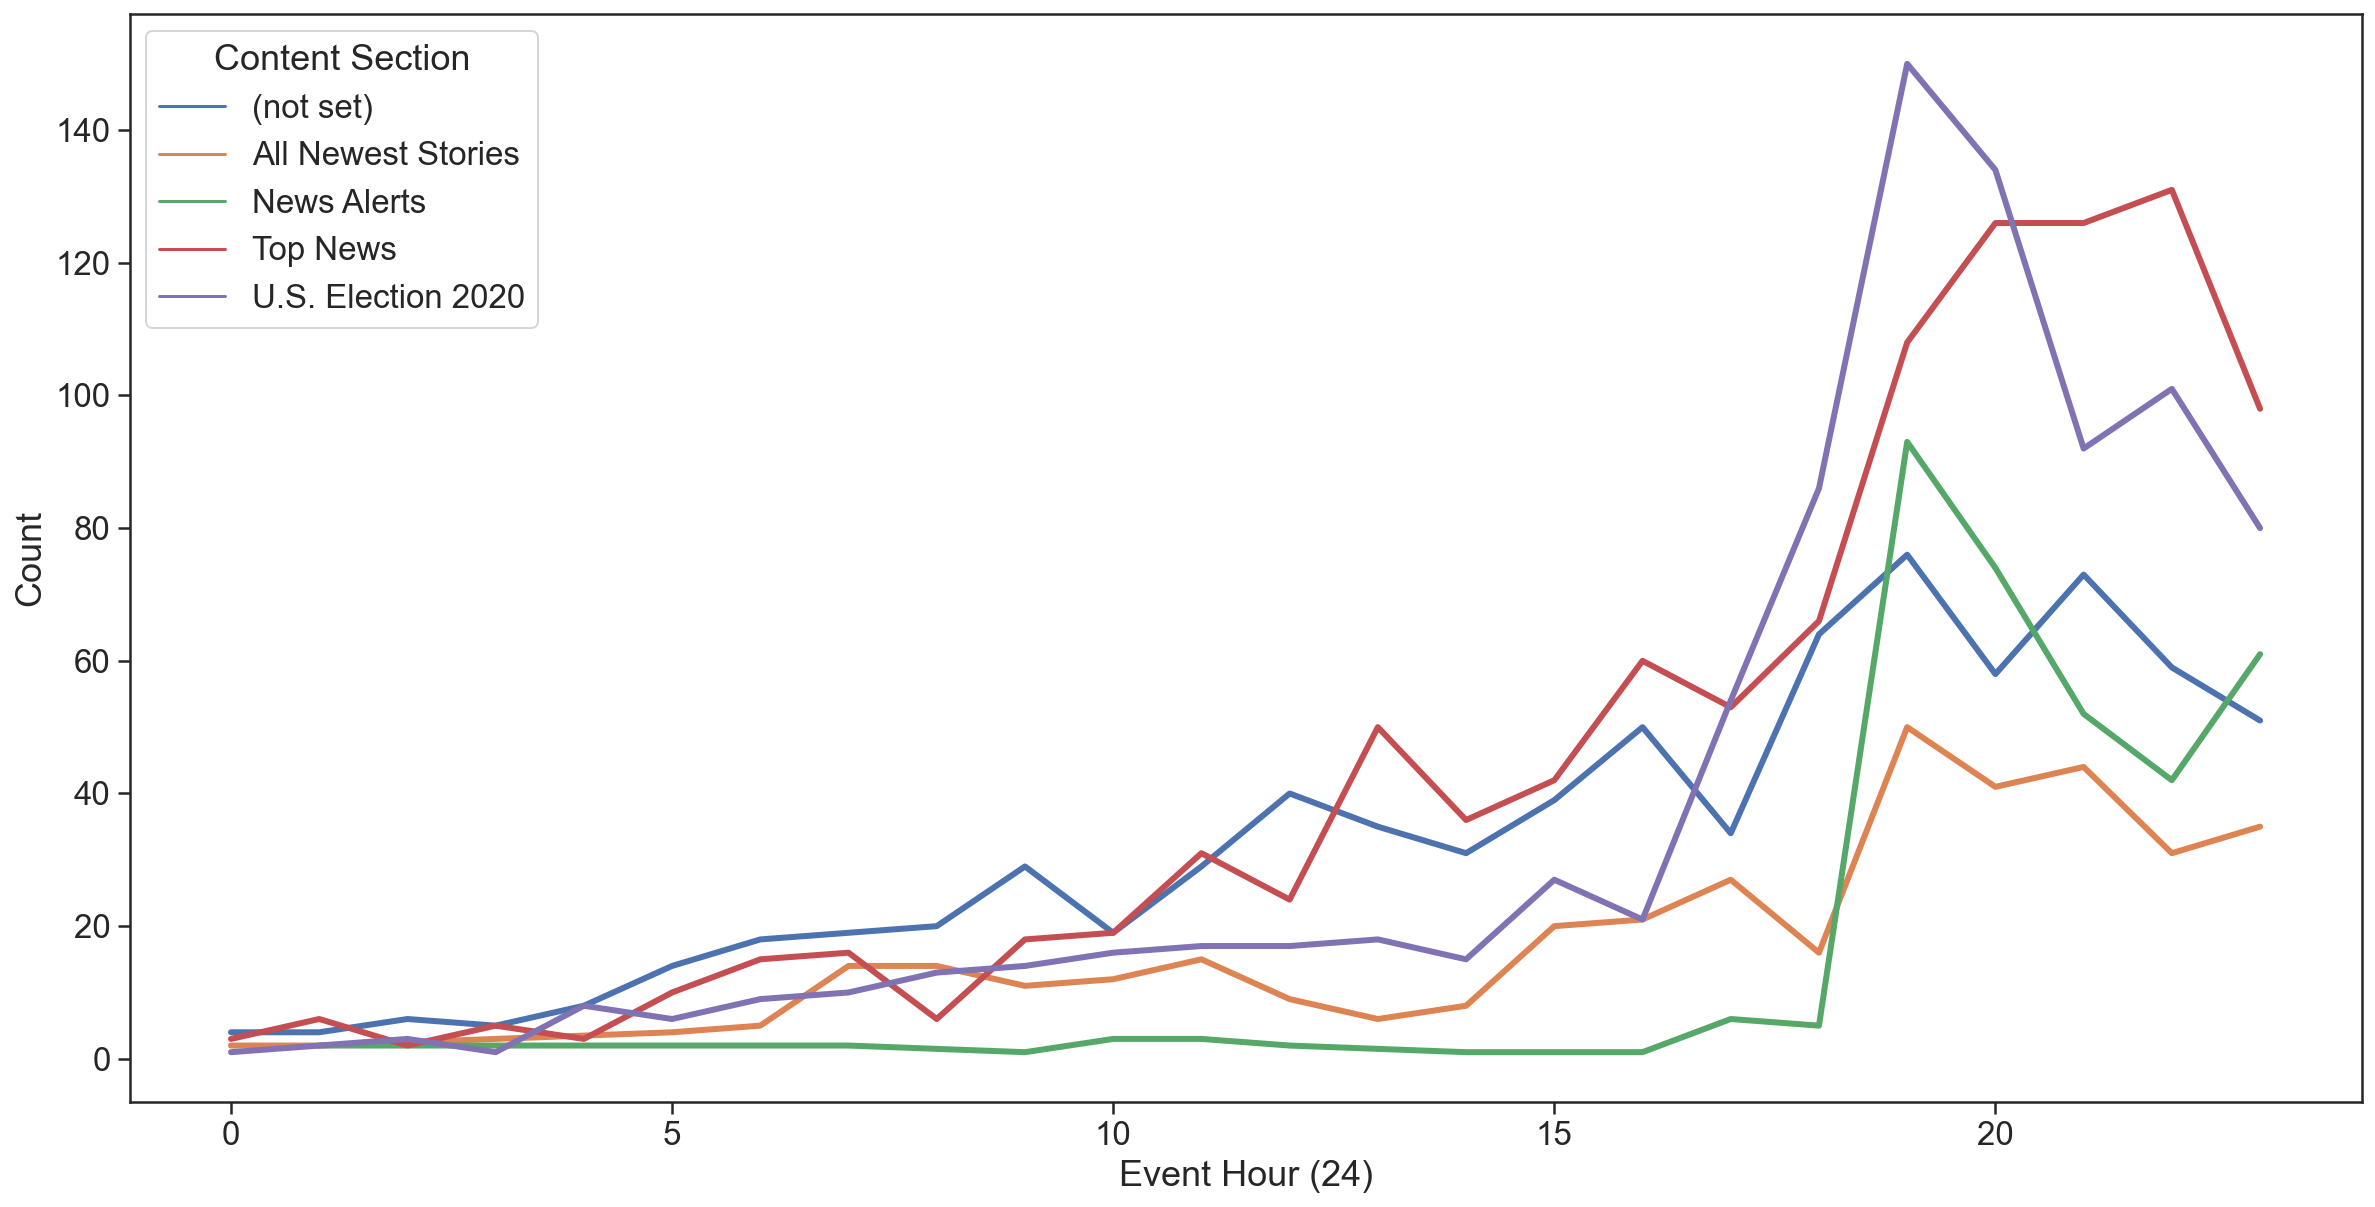

In [19]:
top_5_per_hour = df[df["event_label"].isin(top_10["event_label"][0:5])].groupby(
    ["event_label", "event_hour"]).size().reset_index()
top_5_per_hour = top_5_per_hour.rename(columns={0 : "count"})
ax = sns.lineplot(data=top_5_per_hour, x="event_hour", y="count", hue="event_label", linewidth=3)
ax.set(xlabel="Event Hour (24)", ylabel="Count")
ax.get_legend().set_title("Content Section")
plt.show()

---

In [20]:
connection.close()